In [60]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np

# Fetch data from two directories

Since we have `results_20240126/` and `results_20240131/` stored in S3 bucket, and they have overlapping `JSON` files. After some investigation, the only difference between the data in `results_20240126/` and `results_20240131/` for the same project is the `timestamp` of creation and the order of imports. Therefore, we combine data from two directories and simply choose the data from the latter directory if both directories have it.

In [21]:
# Directories containing JSON files for each project
project_directory_1 = "../experiments/biomedical_projects_experiment/results_20240126/"
project_directory_2 = "../experiments/biomedical_projects_experiment/results_20240131/"

In [26]:
# List of import patterns to store DataFrames for each project
project_dfs_metadata = []
project_dfs_codedirs = []
project_dfs_deps = []
project_dfs_imports = []

In [27]:
# Iterate through JSON files in the directory
for filename in set(os.listdir(project_directory_1) + os.listdir(project_directory_2)):

    file_path_1 = os.path.join(project_directory_1, filename)
    file_path_2 = os.path.join(project_directory_2, filename)

    file_path = file_path_1 if os.path.exists(file_path_1) else file_path_2

    # Load JSON data from the file
    with open(file_path, "r") as file:
        project_data = json.load(file)

    # Extract data from the project_data
    metadata = project_data.get("metadata", {})
    codedirs = project_data.get("code_dirs", {})
    deps_list = project_data.get("deps_file", [])
    imports_list = project_data.get("imports", [])

    # Create a list of dictionaries of code directories
    if codedirs:
        codedirs_dicts = [
            {
                "code directory": key,
                ".py count": value["py"],
                ".ipynb count": value["ipynb"],
                "count": value["total"],
            }
            for key, value in codedirs.items()
        ]
    else:
        codedirs_dicts = [
            {
                "code directory": None,
                ".py count": 0,
                ".ipynb count": 0,
                "count": 0,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    codedirs_data = pd.DataFrame(codedirs_dicts)
    codedirs_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_codedirs.append(codedirs_data)

    # Create a list of dictionaries of dependency declaration files
    deps_dicts = [
        {
            "parser_choice": dep_data["parser_choice"],
            "path": dep_data["path"],
            "deps_count": dep_data["deps_count"],
            "warnings": dep_data["warnings"],
        }
        for dep_data in deps_list
        if deps_list
    ]

    if not deps_list:
        deps_dicts = [
            {
                "parser_choice": None,
                "path": None,
                "deps_count": None,
                "warnings": None,
            }
        ]

    # Create a DataFrame from the list of dictionaries
    deps_data = pd.DataFrame(deps_dicts)
    deps_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_deps.append(deps_data)

    # Create a list of dictionaries of imports
    def _process_import_data(import_data):
        import_type = list(import_data.keys())[0]
        # Combine primary alternative and alternative imports into a single alternative import type
        display_import_type = import_type.removesuffix(" (primary)")
        import_dict = {
            "import_type": display_import_type,
            "name": import_data[import_type]["name"],
            "lineno": import_data[import_type]["source"]["lineno"],
        }
        return import_dict

    imports_dicts = [_process_import_data(import_data) for import_data in imports_list]

    # Create a DataFrame from the list of dictionaries
    imports_data = pd.DataFrame(imports_dicts)
    imports_data["project_name"] = metadata.get("project_name")

    # Append the DataFrame to the list
    project_dfs_imports.append(imports_data)

# Combine all project DataFrames into a single DataFrame
df_codedirs = pd.concat(project_dfs_codedirs, ignore_index=True)
df_deps = pd.concat(project_dfs_deps, ignore_index=True)
df_imports = pd.concat(project_dfs_imports, ignore_index=True)

# Code directories

In [25]:
df_codedirs["project_name"].nunique()

2225

In [29]:
count_df_codedirs = (
    df_codedirs.groupby("project_name").size().reset_index(name="codedirs_count")
)

In [30]:
count_df_codedirs

,project_name,codedirs_count
0,1kp,3
1,2013-khmer-counting,2
2,2018_Bacterial_Pipeline_riboseq,1
3,2018_ecoli_pathogenicity,2
4,2018_mcquin_PLOSBio,1
...,...,...
2220,yamlmatlab,1
2221,yapic,4
2222,yarl,5
2223,yeadon,6


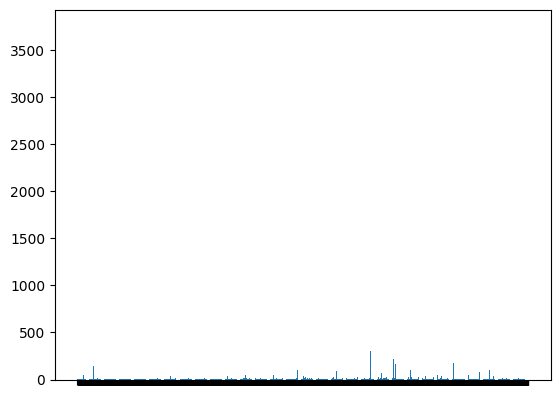

In [40]:
plt.bar("project_name", "codedirs_count", data=count_df_codedirs)
plt.gca().set_xticklabels([])
plt.show()

In [38]:
count_df_codedirs[count_df_codedirs["codedirs_count"] > 400]

,project_name,codedirs_count
643,airflow,1157
825,checkov,608
1154,google-cloud-python,3740
1853,ray,632
2121,transformers,637


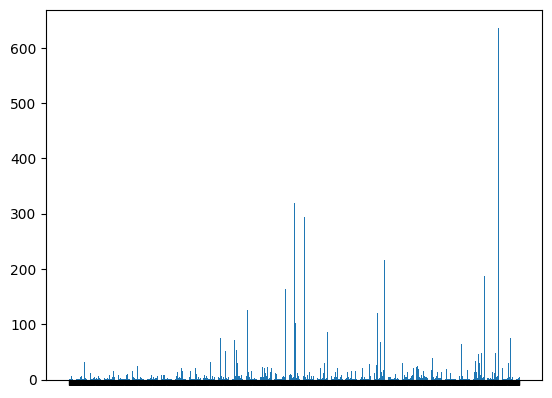

In [39]:
plt.bar(
    "project_name",
    "codedirs_count",
    data=count_df_codedirs[count_df_codedirs["codedirs_count"] < 650],
)
plt.gca().set_xticklabels([])
plt.show()

In [43]:
df_codedirs_max = df_codedirs.loc[df_codedirs.groupby("project_name")["count"].idxmax()]

# Divide projects into three groups by code directory patterns
same_name_projects = df_codedirs_max[
    df_codedirs_max["code directory"] == df_codedirs_max["project_name"]
]["project_name"].tolist()

src_projects = df_codedirs_max.dropna()[
    df_codedirs_max.dropna()["code directory"].str.startswith("src")
]["project_name"].tolist()

no_dir_projects = df_codedirs_max[df_codedirs_max["code directory"].isnull()][
    "project_name"
].tolist()

rest_projects = df_codedirs_max[
    ~df_codedirs_max["project_name"].isin(
        same_name_projects + src_projects + no_dir_projects
    )
]["project_name"].tolist()

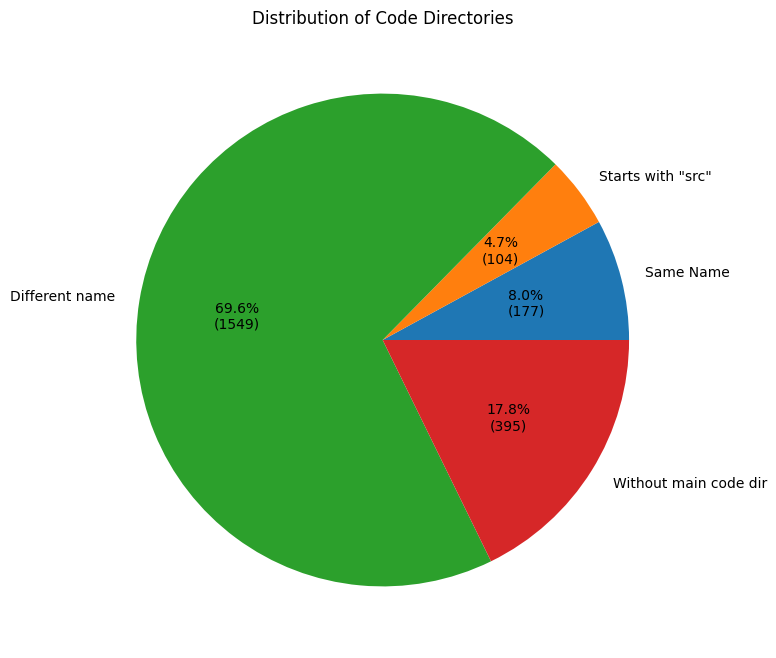

In [44]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame(
    {
        "Category": [
            "Same Name",
            'Starts with "src"',
            "Different name",
            "Without main code dir",
        ],
        "Percentage": [
            len(same_name_projects),
            len(src_projects),
            len(rest_projects),
            len(no_dir_projects),
        ],
        "Projects": [same_name_projects, src_projects, rest_projects, no_dir_projects],
    }
)


def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return "{:.1f}%\n({v:d})".format(pct, v=val)

    return my_format


# Plotting as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    plot_data["Percentage"],
    labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
    autopct=autopct_format(plot_data["Percentage"]),
)
plt.title("Distribution of Code Directories")
plt.show()

# Dependency declaration files

In [45]:
df_deps

,parser_choice,path,deps_count,warnings,project_name
0,setup.cfg,setup.cfg,0,False,python-citrination-client
1,setup.py,setup.py,8,False,python-citrination-client
2,requirements.txt,requirements.txt,6,False,python-citrination-client
3,None,None,None,None,wrk
4,None,None,None,None,FIP-NDP52-paper
...,...,...,...,...,...
5104,setup.py,setup.py,1,False,crosstalk-correction
5105,requirements.txt,requirements.txt,0,False,docker-sra
5106,pyproject.toml,pyproject.toml,9,False,traitlets
5107,setup.py,setup.py,0,False,DataHackLeiden


In [48]:
# Divide projects into three groups by parser choice
project_req_txt = set(
    df_deps[df_deps["parser_choice"] == "requirements.txt"].loc[
        df_deps["deps_count"] > 0
    ]["project_name"]
)
project_pyproject_toml = set(
    df_deps[df_deps["parser_choice"] == "pyproject.toml"].loc[
        df_deps["deps_count"] > 0
    ]["project_name"]
)
project_setup = set(
    df_deps.dropna()[df_deps.dropna()["parser_choice"].str.startswith("setup")][
        "project_name"
    ]
)
project_no_deps = set(df_deps[df_deps["parser_choice"].isnull()]["project_name"])

In [49]:
project_req_only = project_req_txt - project_pyproject_toml - project_setup
project_toml_only = project_pyproject_toml - project_req_txt - project_setup
project_setup_only = project_setup - project_req_txt - project_pyproject_toml
project_req_toml = project_req_txt.intersection(
    project_pyproject_toml
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_setup = project_req_txt.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_toml_setup = project_pyproject_toml.intersection(
    project_setup
) - project_req_txt.intersection(project_pyproject_toml).intersection(project_setup)
project_req_toml_setup = project_req_txt.intersection(
    project_pyproject_toml
).intersection(project_setup)

In [50]:
df_deps_count = pd.DataFrame(
    dict(
        type_=[
            "requirements.txt only",
            "pyproject.toml only",
            "setup.py/setup.cfg only",
            "requirements.txt and pyproject.toml",
            "requirements.txt and setup.py/setup.cfg",
            "pyproject.toml and setup.py/setup.cfg",
            "requirements.txt, pyproject.toml and setup.py/setup.cfg",
            "no dependency declaration files",
        ],
        count=[
            len(project_req_only),
            len(project_toml_only),
            len(project_setup_only),
            len(project_req_toml),
            len(project_req_setup),
            len(project_toml_setup),
            len(project_req_toml_setup),
            len(project_no_deps),
        ],
    )
)

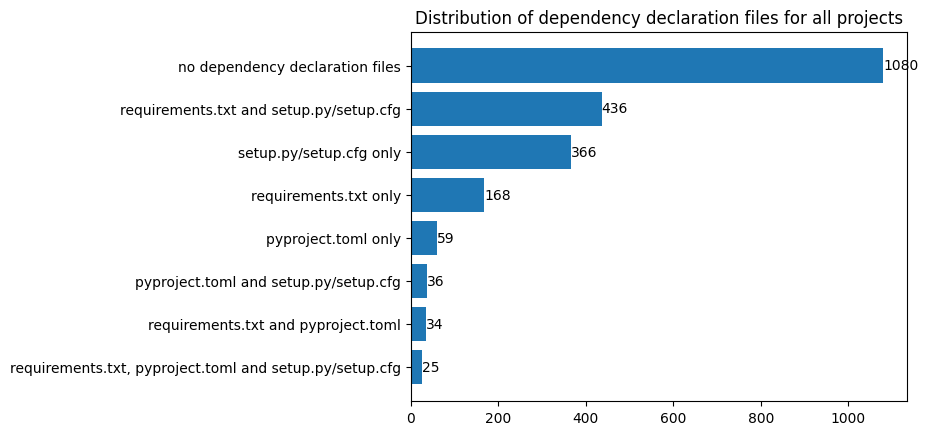

In [51]:
df_deps_count_sorted = df_deps_count.sort_values("count")
fig, ax = plt.subplots()
bars = plt.barh("type_", "count", data=df_deps_count_sorted)

ax.bar_label(bars)
plt.title("Distribution of dependency declaration files for all projects")
plt.show()

# Import patterns

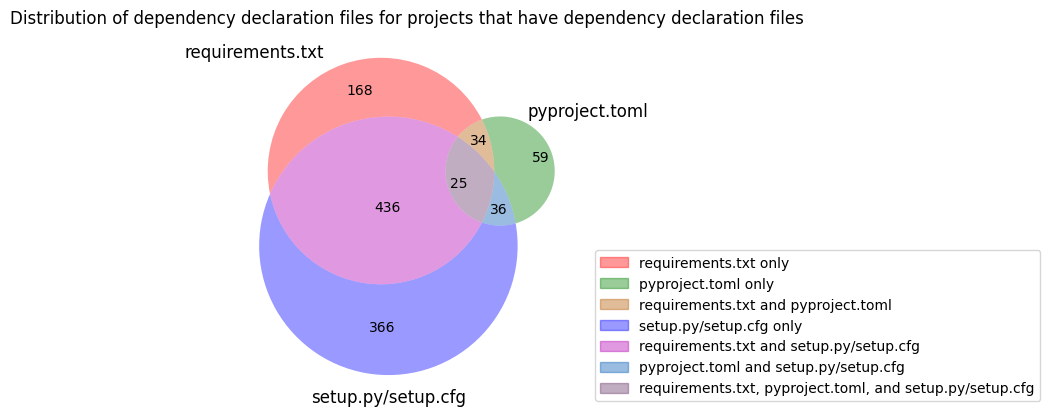

In [53]:
# Draw a venn diagram
plt.figure()
ax = plt.gca()

set_1_name = "requirements.txt"
set_2_name = "pyproject.toml"
set_3_name = "setup.py/setup.cfg"

venn_parsers = venn3(
    [project_req_txt, project_pyproject_toml, project_setup],
    set_labels=(set_1_name, set_2_name, set_3_name),
    ax=ax,
)

# Define labels for all sets and intersections
# for a 3-circle diagram, the sequence is 100, 010, 110, 001, 101, 011, 111
legend_labels = [
    f"{set_1_name} only",
    f"{set_2_name} only",
    f"{set_1_name} and {set_2_name}",
    f"{set_3_name} only",
    f"{set_1_name} and {set_3_name}",
    f"{set_2_name} and {set_3_name}",
    f"{set_1_name}, {set_2_name}, and {set_3_name}",
]

legend_handles = [
    Patch(
        color=patch.get_facecolor(),
        label=legend_labels[venn_parsers.patches.index(patch)],
    )
    for patch in venn_parsers.patches
    if patch
]

plt.legend(handles=legend_handles, loc=(1.04, 0))
plt.title(
    "Distribution of dependency declaration files for projects that have dependency declaration files"
)
plt.show()

In [54]:
df_imports.head()

,import_type,name,lineno,project_name
0,Regular,six,4.0,python-citrination-client
1,Regular,pypif,7.0,python-citrination-client
2,Regular,requests,12.0,python-citrination-client
3,Regular,pypif,1.0,python-citrination-client
4,Regular,pypif,1.0,python-citrination-client


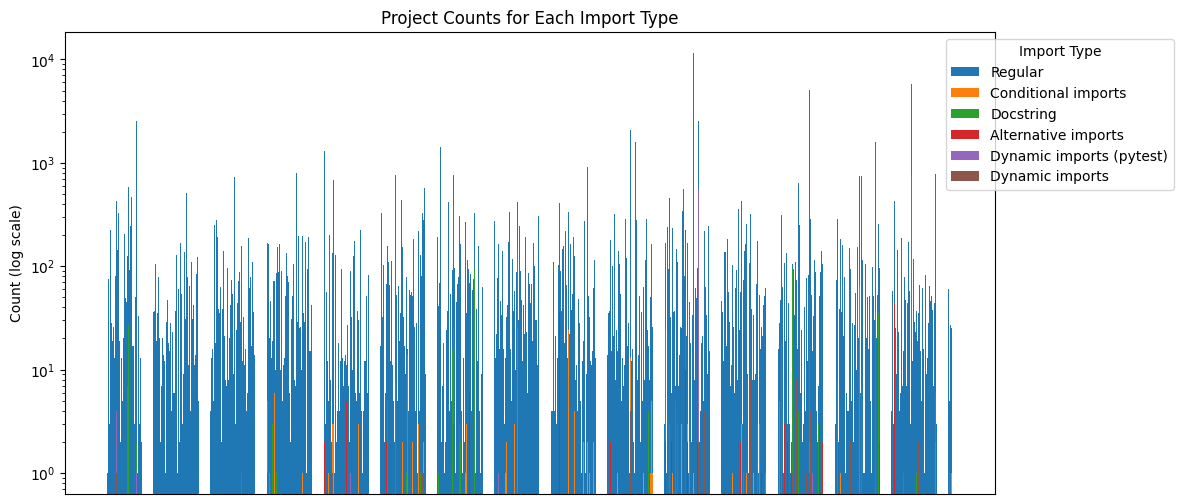

In [55]:
# Create a bar plot for the counts of each import type
frame = plt.figure(figsize=(12, 6))

# Iterate over unique import types and plot a bar for each
for import_type in df_imports["import_type"].unique():
    import_type_data = df_imports[df_imports["import_type"] == import_type]
    project_counts = import_type_data.groupby("project_name").size()
    plt.bar(project_counts.index, project_counts, label=import_type)
    plt.yscale("log")  # Apply log scale to the y-axis for the plot
    plt.ylabel("Count (log scale)")
    plt.title("Project Counts for Each Import Type")
    plt.legend(title="Import Type", loc="upper right", bbox_to_anchor=(1.2, 1))
    # Hide x axis
    for axis in frame.axes:
        axis.get_xaxis().set_visible(False)

# Set the common x-axis label
plt.xlabel("Project Name")

plt.show()

In [56]:
# Divide projects into three groups by parser choice
project_conditional_imports = set(
    df_imports[df_imports["import_type"] == "Conditional imports"]["project_name"]
)
project_alternative_imports = set(
    df_imports[df_imports["import_type"] == "Alternative imports"]["project_name"]
)
project_dynamic_imports = set(
    df_imports[df_imports["import_type"] == "Dynamic imports"]["project_name"]
)
project_docstring = set(
    df_imports[df_imports["import_type"] == "Docstring"]["project_name"]
)
project_all = set(df_codedirs["project_name"])

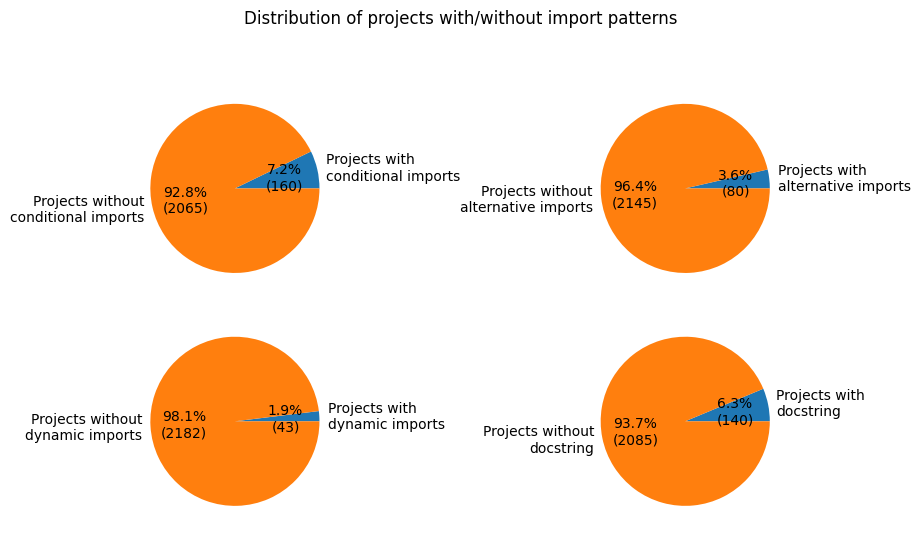

In [57]:
def create_plot_data(import_pattern, import_set):
    return pd.DataFrame(
        {
            "Category": [
                f"Projects with \n{import_pattern}",
                f"Projects without\n{import_pattern}",
            ],
            "Percentage": [
                len(import_set),
                len(project_all) - len(import_set),
            ],
        }
    )


def create_pie_chart(plot_data, axis):
    axis.pie(
        plot_data["Percentage"],
        labels=plot_data.apply(lambda x: f"{x['Category']}", axis=1),
        autopct=autopct_format(plot_data["Percentage"]),
    )


figure, axis = plt.subplots(2, 2, figsize=(9, 6), layout="compressed")

create_pie_chart(
    create_plot_data("conditional imports", project_conditional_imports), axis[0, 0]
)
create_pie_chart(
    create_plot_data("alternative imports", project_alternative_imports), axis[0, 1]
)
create_pie_chart(
    create_plot_data("dynamic imports", project_dynamic_imports), axis[1, 0]
)
create_pie_chart(create_plot_data("docstring", project_docstring), axis[1, 1])

plt.suptitle("Distribution of projects with/without import patterns")
plt.show()

# Correlations

In [58]:
df_codedirs

,code directory,.py count,.ipynb count,count,project_name
0,docs/source/code_samples/data,18,0,18,python-citrination-client
1,citrination_client/search/pif/query/core,16,0,16,python-citrination-client
2,docs/source/code_samples/views,15,0,15,python-citrination-client
3,citrination_client/models/columns,12,0,12,python-citrination-client
4,citrination_client/models,10,0,10,python-citrination-client
...,...,...,...,...,...
27028,.,1,1,2,DataHackLeiden
27029,tavernaPlayerClient,1,1,2,DataHackLeiden
27030,test,1,0,1,DataHackLeiden
27031,examples,0,1,1,DataHackLeiden


In [28]:
df_codedirs[df_codedirs["code directory"] == "notebooks"]

,code directory,.py count,.ipynb count,count,project_name
28,notebooks,0,1,1,enzo
59,notebooks,0,11,11,Adipocyte-U-net
114,notebooks,3,15,18,carboxecoli
158,notebooks,0,2,2,dtoolai
330,notebooks,6,5,11,dtrace
333,notebooks,0,7,7,dials_refinement_brewster2018
408,notebooks,0,1,1,copycat-layout
716,notebooks,0,12,12,chemfin-plasp
1075,notebooks,0,8,8,crossmodel_prediction
1085,notebooks,0,2,2,De_novo_design_SARSCOV2


In [61]:
conditions = [
    (df_codedirs_max["project_name"].isin(project_req_only)),
    (df_codedirs_max["project_name"].isin(project_toml_only)),
    (df_codedirs_max["project_name"].isin(project_setup_only)),
    (df_codedirs_max["project_name"].isin(project_req_toml)),
    (df_codedirs_max["project_name"].isin(project_req_setup)),
    (df_codedirs_max["project_name"].isin(project_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_req_toml_setup)),
    (df_codedirs_max["project_name"].isin(project_no_deps)),
]

# create a list of the values we want to assign for each condition
values = [
    "requirements.txt only",
    "pyproject.toml only",
    "setup.py/setup.cfg only",
    "requirements.txt and pyproject.toml",
    "requirements.txt and setup.py/setup.cfg",
    "pyproject.toml and setup.py/setup.cfg",
    "requirements.txt, pyproject.toml and setup.py/setup.cfg",
    "no dependency declaration files",
]

# create a new column and use np.select to assign values to it using our lists as arguments
df_codedirs_max["deps"] = np.select(conditions, values)

In [62]:
df_codedirs_max[".ipynb>=5"] = np.where(
    df_codedirs_max[".ipynb count"] >= 5, True, False
)

In [63]:
df_codedirs_max

,code directory,.py count,.ipynb count,count,project_name,deps,.ipynb>=5
782,scripts/genealignmenttree,6,0,6,1kp,no dependency declaration files,False
1168,pipeline,8,0,8,2013-khmer-counting,no dependency declaration files,False
10326,.,4,3,7,2018_Bacterial_Pipeline_riboseq,no dependency declaration files,False
11423,src,12,0,12,2018_ecoli_pathogenicity,no dependency declaration files,False
13096,None,0,0,0,2018_mcquin_PLOSBio,no dependency declaration files,False
...,...,...,...,...,...,...,...
12081,None,0,0,0,yamlmatlab,no dependency declaration files,False
4622,yapic,7,0,7,yapic,setup.py/setup.cfg only,False
16210,tests,12,0,12,yarl,setup.py/setup.cfg only,False
5192,yeadon,9,0,9,yeadon,requirements.txt and setup.py/setup.cfg,False


<Axes: xlabel='count', ylabel='deps'>

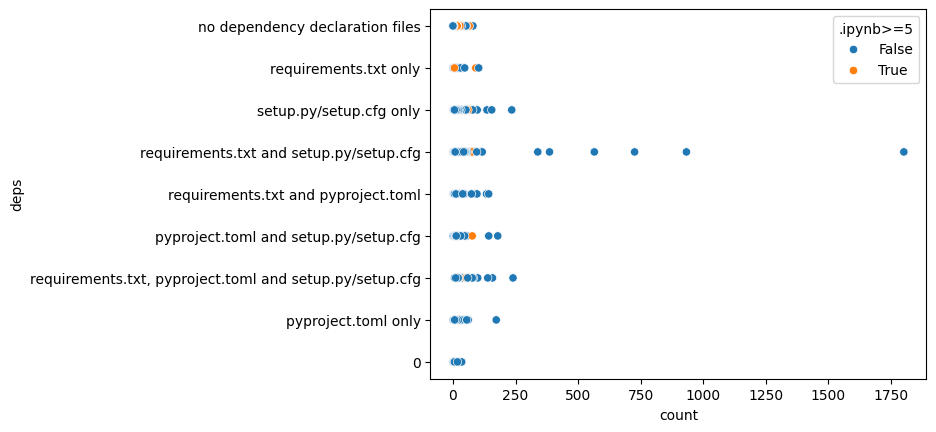

In [67]:
sns.scatterplot(data=df_codedirs_max, x="count", y="deps", hue=".ipynb>=5")

In [68]:
df_codedirs_max[df_codedirs_max["count"] > 200]

,code directory,.py count,.ipynb count,count,project_name,deps,.ipynb>=5
20052,xlsxwriter/test/comparison,933,0,933,XlsxWriter,requirements.txt and setup.py/setup.cfg,False
2207,sdks/python/client/argo_workflows/model,386,0,386,argo,requirements.txt and setup.py/setup.cfg,False
17369,Tests,235,0,235,biopython,setup.py/setup.cfg only,False
20488,checkov/terraform/checks/resource/aws,339,0,339,checkov,requirements.txt and setup.py/setup.cfg,False
5834,packages/google-cloud-compute/samples/generate...,726,0,726,google-cloud-python,requirements.txt and setup.py/setup.cfg,False
2126,kubernetes/client/models,565,0,565,python,requirements.txt and setup.py/setup.cfg,False
17833,samples/generated_samples,1802,0,1802,python-aiplatform,requirements.txt and setup.py/setup.cfg,False
2238,python/ray/tests,240,0,240,ray,"requirements.txt, pyproject.toml and setup.py/...",False
